In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/article-classification/train.csv
/kaggle/input/article-classification/test.csv


--- Data Preprocessing ---
Error: train.csv or test.csv not found.
Loaded data from Kaggle path.
Loaded train.csv: (7769, 2)
Loaded test.csv: (3019, 2)
Handled potential missing values.
Applying text cleaning to documents...
Text cleaning complete.

Parsing and binarizing labels...
Number of unique labels found: 90
Shape of binarized training labels: (7769, 90)
Shape of binarized test labels: (3019, 90)
Labels binarized.

Calculating TF-IDF features from scratch...
Vocabulary size limited to top 5000 features by IDF.
Shape of TF-IDF training features: (7769, 5000)
Shape of TF-IDF test features: (3019, 5000)
TF-IDF calculation complete.

Split training data into training and validation sets:
X_train shape: (6603, 5000), y_train shape: (6603, 90)
X_val shape: (1166, 5000), y_val shape: (1166, 90)
X_test shape: (3019, 5000), y_test shape: (3019, 90)

MLPClassifierMultiLabel class defined (with Momentum).

--- Hyperparameter Tuning & Evaluation ---
Input features: 5000, Output labels: 90
D

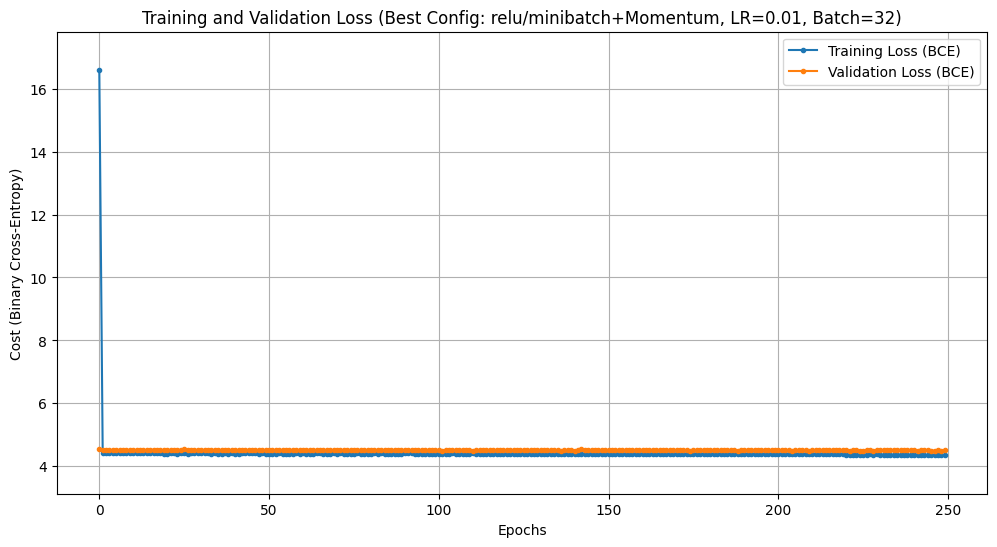


--- Analysis Complete ---


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re # Regular expressions for cleaning
import time
import math
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer # Helpful for multi-label format
from sklearn.metrics import accuracy_score, hamming_loss, f1_score # Multi-label metrics

# Set random seed for reproducibility
np.random.seed(42)

# --- Constants ---
# Using common English stop words (can be expanded)
STOP_WORDS = set([
    'a', 'an', 'and', 'are', 'as', 'at', 'be', 'by', 'for', 'from', 'has', 'he',
    'in', 'is', 'it', 'its', 'of', 'on', 'that', 'the', 'to', 'was', 'were',
    'will', 'with', 'i', 'you', 'your', 's', 't', 'm', 're', 'll', 'd', 've',
    'about', 'k', 'co', 'inc', 'ltd', 'mln', 'pct', 'dlrs', 'said', 'cts' # Added domain-specific noise words
])
MAX_FEATURES = 5000 # Limit TF-IDF features

# --- 2.3.1 Data Preprocessing ---
print("--- Data Preprocessing ---")

# Load Data
try:
    df_train_orig = pd.read_csv('train.csv')
    df_test_orig = pd.read_csv('test.csv')
    print(f"Loaded train.csv: {df_train_orig.shape}")
    print(f"Loaded test.csv: {df_test_orig.shape}")
except FileNotFoundError:
    print("Error: train.csv or test.csv not found.")
    try:
        df_train_orig = pd.read_csv('/kaggle/input/article-classification/train.csv')
        df_test_orig = pd.read_csv('/kaggle/input/article-classification/test.csv')
        print("Loaded data from Kaggle path.")
        print(f"Loaded train.csv: {df_train_orig.shape}")
        print(f"Loaded test.csv: {df_test_orig.shape}")
    except FileNotFoundError:
        print("Error: Files also not found at Kaggle path.")
        print("Exiting script.")
        exit()


# Handle potential missing values (if any)
df_train_orig.dropna(subset=['document', 'category'], inplace=True)
df_test_orig.dropna(subset=['document', 'category'], inplace=True)
print("Handled potential missing values.")

# --- Text Cleaning ---
def preprocess_text(text):
    if not isinstance(text, str): return ""
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s-]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = ' '.join([word for word in text.split() if word not in STOP_WORDS and len(word) > 1])
    return text

print("Applying text cleaning to documents...")
df_train_orig['cleaned_document'] = df_train_orig['document'].apply(preprocess_text)
df_test_orig['cleaned_document'] = df_test_orig['document'].apply(preprocess_text)
print("Text cleaning complete.")

# --- Label Parsing and Binarization ---
def parse_labels(categories):
    if isinstance(categories, str): return [label.strip() for label in categories.split(',')]
    return []

print("\nParsing and binarizing labels...")
train_labels_list = df_train_orig['category'].apply(parse_labels).tolist()
test_labels_list = df_test_orig['category'].apply(parse_labels).tolist()

mlb = MultiLabelBinarizer()
y_train_bin = mlb.fit_transform(train_labels_list)
known_classes = set(mlb.classes_)
test_labels_list_filtered = [[lbl for lbl in labels if lbl in known_classes] for labels in test_labels_list]
y_test_bin = mlb.transform(test_labels_list_filtered)

print(f"Number of unique labels found: {len(mlb.classes_)}")
print(f"Shape of binarized training labels: {y_train_bin.shape}") # (samples, labels)
print(f"Shape of binarized test labels: {y_test_bin.shape}")   # (samples, labels)
print("Labels binarized.")

# --- TF-IDF from Scratch ---
# (TF-IDF Class definition remains the same as before)
class TfidfVectorizerScratch:
    def __init__(self, max_features=None):
        self.max_features = max_features
        self._vocab = {}
        self._idf = {}
        self._feature_names = []

    def _build_vocab(self, corpus):
        doc_freq = defaultdict(int)
        term_counts = Counter()
        total_docs = len(corpus)
        for doc in corpus:
            seen_in_doc = set()
            words = doc.split()
            term_counts.update(words)
            for word in words:
                if word not in seen_in_doc:
                    doc_freq[word] += 1
                    seen_in_doc.add(word)
        temp_idf = {}
        for word, freq in doc_freq.items():
            temp_idf[word] = math.log(total_docs / (freq + 1)) + 1
        if self.max_features and len(temp_idf) > self.max_features:
            sorted_terms = sorted(temp_idf.items(), key=lambda item: (item[1], term_counts[item[0]]), reverse=True)
            top_terms = [term for term, score in sorted_terms[:self.max_features]]
            self._vocab = {term: i for i, term in enumerate(top_terms)}
            self._feature_names = top_terms
            self._idf = {term: temp_idf[term] for term in top_terms}
            print(f"Vocabulary size limited to top {self.max_features} features by IDF.")
        else:
            self._vocab = {word: i for i, word in enumerate(doc_freq.keys())}
            self._idf = temp_idf
            self._feature_names = list(self._vocab.keys())
            print(f"Vocabulary size: {len(self._vocab)}")

    def fit(self, corpus):
        self._build_vocab(corpus)
        return self
    def transform(self, corpus):
        n_docs = len(corpus)
        n_features = len(self._vocab)
        tfidf_matrix = np.zeros((n_docs, n_features))
        for i, doc in enumerate(corpus):
            words = doc.split()
            doc_len = len(words)
            if doc_len == 0: continue
            term_counts_in_doc = Counter(words)
            for word, count in term_counts_in_doc.items():
                if word in self._vocab:
                    tf = count / doc_len
                    idf = self._idf.get(word, 0)
                    feature_index = self._vocab[word]
                    tfidf_matrix[i, feature_index] = tf * idf
        return tfidf_matrix
    def fit_transform(self, corpus):
        self.fit(corpus)
        return self.transform(corpus)
    def get_feature_names_out(self):
        return self._feature_names

print("\nCalculating TF-IDF features from scratch...")
vectorizer = TfidfVectorizerScratch(max_features=MAX_FEATURES)
X_train_tfidf = vectorizer.fit_transform(df_train_orig['cleaned_document'])
X_test_tfidf = vectorizer.transform(df_test_orig['cleaned_document'])
print(f"Shape of TF-IDF training features: {X_train_tfidf.shape}") # (samples, features)
print(f"Shape of TF-IDF test features: {X_test_tfidf.shape}")   # (samples, features)
print("TF-IDF calculation complete.")

# --- Splitting Training Data ---
X_train, X_val, y_train, y_val = train_test_split(
    X_train_tfidf, y_train_bin, test_size=0.15, random_state=42
)
print("\nSplit training data into training and validation sets:")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}") # (samples, features/labels)
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")       # (samples, features/labels)
print(f"X_test shape: {X_test_tfidf.shape}, y_test shape: {y_test_bin.shape}") # (samples, features/labels)

# --- Activation Functions (Same as before) ---
def sigmoid(Z):
    A = 1 / (1 + np.exp(-np.clip(Z, -500, 500)))
    return A, Z
def sigmoid_backward(dA, cache):
    Z = cache
    s = 1 / (1 + np.exp(-np.clip(Z, -500, 500)))
    dZ = dA * s * (1 - s)
    return dZ
def relu(Z):
    A = np.maximum(0, Z)
    return A, Z
def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    return dZ
def tanh(Z):
    A = np.tanh(Z)
    return A, Z
def tanh_backward(dA, cache):
    Z = cache
    t = np.tanh(Z)
    dZ = dA * (1 - np.power(t, 2))
    return dZ

# --- MLP Class with Momentum ---
class MLPClassifierMultiLabel:
    def __init__(self, layer_dims, learning_rate=0.01, activation='relu',
                 optimizer='minibatch', momentum=0.9, # Added momentum param
                 epochs=100, batch_size=64,
                 random_state=None, print_cost_every=10):
        self.layer_dims = layer_dims
        self.learning_rate = learning_rate
        self.hidden_activation_name = activation.lower()
        self.optimizer = optimizer.lower() # Keep optimizer param for potential future extension (sgd, batch)
        self.momentum = momentum # Store momentum factor
        self.epochs = epochs
        self.batch_size = batch_size
        self.random_state = random_state
        self.print_cost_every = print_cost_every

        self.parameters = {}
        self.v = {} # Initialize velocity dictionary for momentum
        self.costs_train = []
        self.costs_val = []
        self.hidden_activation_forward = None
        self.hidden_activation_backward = None
        self.output_activation_forward = sigmoid
        self.output_activation_backward = sigmoid_backward

        self._select_hidden_activation()
        self._initialize_parameters()

    def _select_hidden_activation(self):
        if self.hidden_activation_name == 'sigmoid': self.hidden_activation_forward, self.hidden_activation_backward = sigmoid, sigmoid_backward
        elif self.hidden_activation_name == 'tanh': self.hidden_activation_forward, self.hidden_activation_backward = tanh, tanh_backward
        elif self.hidden_activation_name == 'relu': self.hidden_activation_forward, self.hidden_activation_backward = relu, relu_backward
        else: raise ValueError("Invalid hidden activation. Choose 'sigmoid', 'tanh', or 'relu'.")

    def _initialize_parameters(self):
        if self.random_state is not None: np.random.seed(self.random_state)
        L = len(self.layer_dims)
        for l in range(1, L):
            scale_factor = np.sqrt(1. / self.layer_dims[l-1])
            if self.hidden_activation_name == 'relu' and l < L - 1: scale_factor = np.sqrt(2. / self.layer_dims[l-1])
            elif self.hidden_activation_name == 'relu' and l == L - 1: scale_factor = np.sqrt(1. / self.layer_dims[l-1])

            self.parameters['W' + str(l)] = np.random.randn(self.layer_dims[l], self.layer_dims[l-1]) * scale_factor
            self.parameters['b' + str(l)] = np.zeros((self.layer_dims[l], 1))

            # Initialize velocity terms for momentum with zeros
            self.v["dW" + str(l)] = np.zeros_like(self.parameters["W" + str(l)])
            self.v["db" + str(l)] = np.zeros_like(self.parameters["b" + str(l)])

    # --- Forward Propagation (Same as before) ---
    def _linear_forward(self, A_prev, W, b):
        Z = np.dot(W, A_prev) + b
        return Z, (A_prev, W, b)
    def _linear_activation_forward(self, A_prev, W, b, activation_func):
        Z, linear_cache = self._linear_forward(A_prev, W, b)
        A, activation_cache = activation_func(Z)
        return A, (linear_cache, activation_cache)
    def _forward_propagation(self, X):
        caches = []
        A = X
        L = len(self.parameters) // 2
        for l in range(1, L):
            A, cache = self._linear_activation_forward(A, self.parameters['W' + str(l)], self.parameters['b' + str(l)], self.hidden_activation_forward)
            caches.append(cache)
        AL, cache_L = self._linear_activation_forward(A, self.parameters['W' + str(L)], self.parameters['b' + str(L)], self.output_activation_forward)
        caches.append(cache_L)
        if np.any(np.isnan(AL)) or np.any(np.isinf(AL)): print("Warning: NaN/Inf in AL")
        return AL, caches

    # --- Cost Function (Same as before) ---
    def _compute_cost(self, AL, Y):
        m = Y.shape[1]
        epsilon = 1e-8
        AL_clipped = np.clip(AL, epsilon, 1 - epsilon)
        cost = -(1/m) * np.sum(Y * np.log(AL_clipped) + (1 - Y) * np.log(1 - AL_clipped))
        cost = np.squeeze(cost)
        if np.isnan(cost) or np.isinf(cost):
             print("Warning: NaN or Inf detected in cost calculation.")
             return np.inf
        return cost

    # --- Backward Propagation (Same as before) ---
    def _linear_backward(self, dZ, linear_cache):
        A_prev, W, b = linear_cache
        m = A_prev.shape[1]
        dW = (1 / m) * np.dot(dZ, A_prev.T)
        db = (1 / m) * np.sum(dZ, axis=1, keepdims=True)
        dA_prev = np.dot(W.T, dZ)
        return dA_prev, dW, db
    def _linear_activation_backward(self, dA, cache, activation_backward_func):
        linear_cache, activation_cache = cache
        dZ = activation_backward_func(dA, activation_cache)
        if np.any(np.isnan(dZ)) or np.any(np.isinf(dZ)): print(f"Warning: NaN/Inf in dZ")
        dA_prev, dW, db = self._linear_backward(dZ, linear_cache)
        return dA_prev, dW, db
    def _backward_propagation(self, AL, Y, caches):
        grads = {}
        L = len(caches)
        m = AL.shape[1]
        Y = Y.reshape(AL.shape)
        epsilon = 1e-8
        AL_clipped = np.clip(AL, epsilon, 1 - epsilon)
        dAL = - (np.divide(Y, AL_clipped) - np.divide(1 - Y, 1 - AL_clipped))
        if np.any(np.isnan(dAL)) or np.any(np.isinf(dAL)):
            print("Warning: NaN or Inf detected in dAL. Replacing.")
            dAL = np.nan_to_num(dAL, nan=0.0, posinf=1e6, neginf=-1e6)
        current_cache = caches[L-1]
        dA_prev_L, dW_L, db_L = self._linear_activation_backward(dAL, current_cache, self.output_activation_backward)
        grads["dA" + str(L-1)] = dA_prev_L
        grads["dW" + str(L)] = dW_L
        grads["db" + str(L)] = db_L
        for l in reversed(range(L - 1)):
            current_cache = caches[l]
            dA_curr = grads["dA" + str(l + 1)]
            dA_prev, dW_curr, db_curr = self._linear_activation_backward(dA_curr, current_cache, self.hidden_activation_backward)
            grads["dA" + str(l)] = dA_prev
            grads["dW" + str(l + 1)] = dW_curr
            grads["db" + str(l + 1)] = db_curr
        for key, value in grads.items():
            if np.any(np.isnan(value)) or np.any(np.isinf(value)):
                print(f"Warning: NaN or Inf detected in final gradient '{key}'. Replacing.")
                grads[key] = np.nan_to_num(value, nan=0.0, posinf=1e6, neginf=-1e6)
        return grads

    # --- Update Parameters (Minibatch GD with Momentum) ---
    def _update_parameters(self, grads):
        """Updates parameters using Minibatch Gradient Descent with Momentum."""
        L = len(self.parameters) // 2

        for l in range(1, L + 1):
            # Retrieve gradients
            dW = grads["dW" + str(l)]
            db = grads["db" + str(l)]

            # --- Momentum Update ---
            # Update velocity
            self.v["dW" + str(l)] = self.momentum * self.v["dW" + str(l)] + (1 - self.momentum) * dW
            self.v["db" + str(l)] = self.momentum * self.v["db" + str(l)] + (1 - self.momentum) * db

            # Update parameters using velocity
            self.parameters["W" + str(l)] -= self.learning_rate * self.v["dW" + str(l)]
            self.parameters["b" + str(l)] -= self.learning_rate * self.v["db" + str(l)]
            # --- End Momentum Update ---

    # --- Mini-batch Creation (Same as before) ---
    def _create_mini_batches(self, X, Y, batch_size, seed):
        X_contig = np.asfortranarray(X)
        Y_contig = np.asfortranarray(Y)
        np.random.seed(seed)
        m = X.shape[1]
        mini_batches = []
        permutation = list(np.random.permutation(m))
        shuffled_X = X_contig[:, permutation]
        shuffled_Y = Y_contig[:, permutation]
        num_complete_minibatches = math.floor(m / batch_size)
        for k in range(0, num_complete_minibatches):
            mini_batch_X = shuffled_X[:, k * batch_size : (k + 1) * batch_size]
            mini_batch_Y = shuffled_Y[:, k * batch_size : (k + 1) * batch_size]
            mini_batches.append((mini_batch_X, mini_batch_Y))
        if m % batch_size != 0:
            mini_batch_X = shuffled_X[:, num_complete_minibatches * batch_size :]
            mini_batch_Y = shuffled_Y[:, num_complete_minibatches * batch_size :]
            mini_batches.append((mini_batch_X, mini_batch_Y))
        return mini_batches

    # --- Training Loop (Uses Momentum Update) ---
    def fit(self, X_train, y_train, X_val, y_val):
        if self.random_state is not None: np.random.seed(self.random_state)
        seed = self.random_state if self.random_state is not None else 0
        m_train = X_train.shape[1]
        self.costs_train = []
        self.costs_val = []

        print(f"Starting training: {self.epochs} epochs, LR={self.learning_rate}, BatchSize={self.batch_size}, Optimizer={self.optimizer} w/ Momentum={self.momentum}")

        for i in range(self.epochs):
            epoch_start_time = time.time()
            epoch_cost_train = 0.
            seed += 1

            if self.optimizer == 'minibatch':
                mini_batches = self._create_mini_batches(X_train, y_train, self.batch_size, seed)
                current_epoch_costs = []
                num_batches = len(mini_batches)
                for batch_idx, mini_batch in enumerate(mini_batches):
                    (mini_batch_X, mini_batch_Y) = mini_batch
                    AL, caches = self._forward_propagation(mini_batch_X)
                    cost_mini_batch = self._compute_cost(AL, mini_batch_Y)
                    if np.isnan(cost_mini_batch) or np.isinf(cost_mini_batch):
                         print(f"Warning: NaN/Inf cost encountered in epoch {i}, batch {batch_idx+1}/{num_batches}. Skipping grad update.")
                         continue
                    current_epoch_costs.append(cost_mini_batch)
                    grads = self._backward_propagation(AL, mini_batch_Y, caches)
                    self._update_parameters(grads) # Updates with momentum
                if current_epoch_costs: epoch_cost_train = np.mean(current_epoch_costs)
                else: epoch_cost_train = np.nan
            # Add 'sgd' or 'batch' options here if needed, updating parameters accordingly
            else:
                 raise ValueError("Invalid optimizer. Only 'minibatch' supported in this version.")

            # --- Validation cost ---
            AL_val, _ = self._forward_propagation(X_val)
            cost_val = self._compute_cost(AL_val, y_val)

            # Store costs
            if not (np.isnan(epoch_cost_train) or np.isinf(epoch_cost_train)): self.costs_train.append(epoch_cost_train)
            else: self.costs_train.append(self.costs_train[-1] if self.costs_train else np.nan)
            if not (np.isnan(cost_val) or np.isinf(cost_val)): self.costs_val.append(cost_val)
            else: self.costs_val.append(self.costs_val[-1] if self.costs_val else np.nan)

            epoch_end_time = time.time()
            epoch_duration = epoch_end_time - epoch_start_time

            if self.print_cost_every > 0 and i % self.print_cost_every == 0:
                print(f"Epoch {i}/{self.epochs-1} | Train Cost: {epoch_cost_train:.6f} | Val Cost: {cost_val:.6f} | Time: {epoch_duration:.2f}s")
            elif i == self.epochs - 1:
                print(f"Epoch {i}/{self.epochs-1} | Train Cost: {epoch_cost_train:.6f} | Val Cost: {cost_val:.6f} | Time: {epoch_duration:.2f}s")

    # --- Prediction (Same as before) ---
    def predict_proba(self, X):
        AL, _ = self._forward_propagation(X)
        return AL
    def predict(self, X, threshold=0.5):
        probas = self.predict_proba(X)
        return (probas > threshold).astype(int)

    # --- Evaluation (Same as before, with corrected shape check) ---
    def evaluate(self, X, y_true_bin, threshold=0.5):
        y_pred_prob_mlp = self.predict_proba(X)
        y_pred_bin_mlp = (y_pred_prob_mlp > threshold).astype(int)
        y_pred_bin_sklearn = y_pred_bin_mlp.T

        n_samples_eval = X.shape[1]
        n_labels_eval = self.layer_dims[-1]
        if y_true_bin.shape == (n_samples_eval, n_labels_eval):
            y_true_bin_sklearn = y_true_bin
        elif y_true_bin.shape == (n_labels_eval, n_samples_eval):
            y_true_bin_sklearn = y_true_bin.T
            print(f"Transposing y_true_bin from {y_true_bin.shape} to {y_true_bin_sklearn.shape} for evaluation.")
        else:
            raise ValueError(f"Unexpected shape for y_true_bin: {y_true_bin.shape}. Expected ({n_samples_eval}, {n_labels_eval}) or ({n_labels_eval}, {n_samples_eval})")

        if y_true_bin_sklearn.shape != y_pred_bin_sklearn.shape:
             raise ValueError(f"Final shape mismatch: y_true_bin_sklearn {y_true_bin_sklearn.shape} vs y_pred_bin_sklearn {y_pred_bin_sklearn.shape}")

        acc = accuracy_score(y_true_bin_sklearn, y_pred_bin_sklearn)
        hamming = hamming_loss(y_true_bin_sklearn, y_pred_bin_sklearn)
        f1_micro = f1_score(y_true_bin_sklearn, y_pred_bin_sklearn, average='micro', zero_division=0)
        f1_macro = f1_score(y_true_bin_sklearn, y_pred_bin_sklearn, average='macro', zero_division=0)
        f1_samples = f1_score(y_true_bin_sklearn, y_pred_bin_sklearn, average='samples', zero_division=0)
        return acc, hamming, f1_micro, f1_macro, f1_samples

print("\nMLPClassifierMultiLabel class defined (with Momentum).")

# --- 2.3.3 Hyperparameter Tuning & Evaluation ---
print("\n--- Hyperparameter Tuning & Evaluation ---")

# Prepare data shapes (features, examples)
X_train_mlp = X_train.T
y_train_mlp = y_train.T
X_val_mlp = X_val.T
y_val_mlp = y_val.T
X_test_mlp = X_test_tfidf.T
# y_test_bin shape is (samples, labels) - passed directly to evaluate

n_features = X_train_mlp.shape[0]
n_labels = y_train_mlp.shape[0]
print(f"Input features: {n_features}, Output labels: {n_labels}")
print(f"Data shapes for MLP: ")
print(f"  X_train_mlp: {X_train_mlp.shape}, y_train_mlp: {y_train_mlp.shape}")
print(f"  X_val_mlp:   {X_val_mlp.shape}, y_val_mlp:   {y_val_mlp.shape}")
print(f"  X_test_mlp:  {X_test_mlp.shape}, y_test_bin:  {y_test_bin.shape}")

# --- Adjusted Hyperparameter Space (for GD + Momentum) ---
learning_rates = [0.01, 0.005, 0.001] # Smaller LRs more suitable
epochs_list = [150, 250]              # More epochs needed potentially
architectures = [
    [n_features, 128, n_labels],
    [n_features, 256, 128, n_labels]
]
hidden_activations = ['relu', 'tanh']
optimizers = ['minibatch'] # Conceptually minibatch GD (+momentum internally)
batch_sizes = [32, 64]
# Momentum fixed at 0.9 in __init__, but could be added to tune here

results = []
iteration = 0
total_iterations = len(learning_rates) * len(epochs_list) * len(architectures) * len(hidden_activations) * len(optimizers) * len(batch_sizes)

for lr in learning_rates:
    for epochs in epochs_list:
        for arch in architectures:
            for activation in hidden_activations:
                for optimizer in optimizers: # Loop still here, but only one option
                    for batch_size in batch_sizes:
                        iteration += 1
                        print(f"\n--- Running Iteration {iteration}/{total_iterations} ---")
                        print(f"Config: LR={lr}, Epochs={epochs}, Arch={arch}, Act={activation}, Opt={optimizer}+Momentum, Batch={batch_size}")

                        start_time = time.time()

                        mlp = MLPClassifierMultiLabel(layer_dims=arch,
                                           learning_rate=lr,
                                           activation=activation,
                                           optimizer=optimizer,
                                           momentum=0.9, # Using fixed momentum
                                           epochs=epochs,
                                           batch_size=batch_size,
                                           random_state=42,
                                           print_cost_every=20) # Print less often for longer epochs

                        # Train the model
                        mlp.fit(X_train_mlp, y_train_mlp, X_val_mlp, y_val_mlp)

                        end_time = time.time()
                        training_time = end_time - start_time

                        # Evaluate on the Test set
                        acc, hamming, f1_micro, f1_macro, f1_samples = mlp.evaluate(X_test_mlp, y_test_bin, threshold=0.5)

                        print(f"Test Set Results:")
                        print(f"  Accuracy(Subset) = {acc:.4f}")
                        print(f"  Hamming Loss     = {hamming:.4f}")
                        print(f"  F1 Micro         = {f1_micro:.4f}")
                        print(f"  F1 Macro         = {f1_macro:.4f}")
                        print(f"  F1 Samples       = {f1_samples:.4f}")
                        print(f"Training Time: {training_time:.2f} seconds")

                        # Store results
                        results.append({
                            'learning_rate': lr,
                            'epochs': epochs,
                            'architecture': str(arch),
                            'activation': activation,
                            'optimizer': optimizer + '+Momentum', # Indicate momentum used
                            'batch_size': batch_size,
                            'accuracy': acc,
                            'hamming_loss': hamming,
                            'f1_micro': f1_micro,
                            'f1_macro': f1_macro,
                            'f1_samples': f1_samples,
                            'training_time': training_time,
                            'train_costs': mlp.costs_train,
                            'val_costs': mlp.costs_val
                        })

                        # Optional prediction inspection
                        # print("\n--- Prediction Inspection ---")
                        # y_pred_probs = mlp.predict_proba(X_test_mlp)
                        # print(f"Max predicted probability across all labels for first 5 samples: {np.max(y_pred_probs[:, :5], axis=0)}")
                        # print(f"Mean predicted probability across all labels/samples: {np.mean(y_pred_probs)}")
                        # y_pred_bin = mlp.predict(X_test_mlp, threshold=0.5)
                        # y_pred_bin_sum = np.sum(y_pred_bin, axis=0)
                        # print(f"Number of predicted labels for first 5 samples: {y_pred_bin_sum[:5]}")
                        # print(f"Total predicted labels across test set: {np.sum(y_pred_bin_sum)}")
                        # print("--- End Inspection ---")


# --- Reporting (Same as before) ---
print("\n\n--- Experiment Results ---")
if not results: print("No results generated.")
else:
    results_df = pd.DataFrame(results)
    results_df_sorted = results_df.sort_values(by='f1_micro', ascending=False).reset_index(drop=True)
    print("\nTop 5 Configurations (Sorted by F1 Micro Score):")
    print(results_df_sorted[['learning_rate', 'epochs', 'activation', 'optimizer', 'batch_size', 'architecture', 'f1_micro', 'accuracy', 'hamming_loss', 'f1_samples']].head())
    print("\nFull Results Table (Sorted by F1 Micro Score):")
    print(results_df_sorted[['learning_rate', 'epochs', 'activation', 'optimizer', 'batch_size', 'architecture', 'f1_micro', 'accuracy', 'hamming_loss', 'f1_macro','f1_samples', 'training_time']])

    best_config_index = results_df_sorted.index[0]
    original_index = results_df[
        (results_df['learning_rate'] == results_df_sorted.loc[best_config_index, 'learning_rate']) &
        (results_df['epochs'] == results_df_sorted.loc[best_config_index, 'epochs']) &
        (results_df['architecture'] == results_df_sorted.loc[best_config_index, 'architecture']) &
        (results_df['activation'] == results_df_sorted.loc[best_config_index, 'activation']) &
        (results_df['optimizer'] == results_df_sorted.loc[best_config_index, 'optimizer']) & # Match optimizer name
        (results_df['batch_size'] == results_df_sorted.loc[best_config_index, 'batch_size'])
    ].index[0]
    best_config_dict = results[original_index]
    best_config = results_df_sorted.iloc[best_config_index]

    print(f"\nBest Configuration Found (based on F1 Micro):")
    print(f"  Learning Rate: {best_config['learning_rate']}")
    print(f"  Epochs: {best_config['epochs']}")
    print(f"  Architecture: {best_config['architecture']}")
    print(f"  Hidden Activation: {best_config['activation']}")
    print(f"  Optimizer: {best_config['optimizer']}") # Will show 'minibatch+Momentum'
    print(f"  Batch Size: {best_config['batch_size']}")
    print(f"  Test F1 Micro: {best_config['f1_micro']:.4f}")
    print(f"  Test Accuracy (Subset): {best_config['accuracy']:.4f}")
    print(f"  Test Hamming Loss: {best_config['hamming_loss']:.4f}")
    print(f"  Test F1 Macro: {best_config['f1_macro']:.4f}")
    print(f"  Test F1 Samples: {best_config['f1_samples']:.4f}")

    # --- Plotting (Same as before) ---
    print("\n--- Plotting Training Curves for Best Configuration ---")
    best_train_costs = best_config_dict['train_costs']
    best_val_costs = best_config_dict['val_costs']
    epochs_axis_train = [i for i, cost in enumerate(best_train_costs) if not (np.isnan(cost) or np.isinf(cost))]
    valid_train_costs = [cost for cost in best_train_costs if not (np.isnan(cost) or np.isinf(cost))]
    epochs_axis_val = [i for i, cost in enumerate(best_val_costs) if not (np.isnan(cost) or np.isinf(cost))]
    valid_val_costs = [cost for cost in best_val_costs if not (np.isnan(cost) or np.isinf(cost))]
    if not valid_train_costs or not valid_val_costs: print("Warning: No valid costs to plot.")
    else:
        plt.figure(figsize=(12, 6))
        plt.plot(epochs_axis_train, valid_train_costs, label='Training Loss (BCE)', marker='.', linestyle='-')
        plt.plot(epochs_axis_val, valid_val_costs, label='Validation Loss (BCE)', marker='.', linestyle='-')
        plt.title(f'Training and Validation Loss (Best Config: {best_config["activation"]}/{best_config["optimizer"]}, LR={best_config["learning_rate"]}, Batch={best_config["batch_size"]})')
        plt.xlabel('Epochs')
        plt.ylabel('Cost (Binary Cross-Entropy)')
        plt.legend(); plt.grid(True)
        min_cost = min(min(valid_train_costs), min(valid_val_costs)); max_cost = max(max(valid_train_costs), max(valid_val_costs))
        cost_range = max_cost - min_cost; padding = max(0.1 * cost_range, 0.1)
        plt.ylim(max(0, min_cost - padding), max_cost + padding); plt.show()

print("\n--- Analysis Complete ---")